# Import 

In [37]:
import jsonlines
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from scipy.spatial.distance import cosine
from scipy.special import rel_entr as entropy
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import torch

import seaborn as sns
from textstat import flesch_reading_ease
import jsonlines 
from transformers import BertTokenizer, BertModel


nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
sentence_model = SentenceTransformer('paraphrase-distilroberta-base-v1')

bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')



[nltk_data] Downloading package punkt to /Users/jashkina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jashkina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from

# Make Features

In [38]:
def extract_ideas(text):
    text = text.lower()
    ideas = []
    
    lines = text.split("\n")
    for line in lines:
        line = line.strip()
        
        if re.match(r'\d+\.', line):
            idea = re.sub(r'\d+\.', '', line).strip()
            ideas.append(idea)
        
        elif re.match(r'-', line):
            idea = re.sub(r'-', '', line).strip()
            ideas.append(idea)
        
        else:
            ideas.append(line)

    ideas = list(set([idea for idea in ideas if idea]))
    
    return ideas

def load_results(file_path):
    with jsonlines.open(file_path, mode='r') as reader:
        data = [row for row in reader]
    return pd.DataFrame(data)

def bert_embedding(texts, model, tokenizer):
    embeddings_list = []
    for text in texts:
        tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**tokens)
        
        embeddings = outputs.last_hidden_state
        mask = tokens['attention_mask'].unsqueeze(-1).expand(embeddings.shape).float()
        masked_embeddings = embeddings * mask
        summed = torch.sum(masked_embeddings, 1)
        lengths = torch.sum(mask, 1)
        average_embeddings = summed / lengths
        embeddings_list.append(average_embeddings.squeeze().numpy())
    return embeddings_list


def semantic_embedding(texts, model):
    embeddings_list = []
    for text in texts:
        idea_embeddings = model.encode(text)
        embeddings_list.append(idea_embeddings)
    return embeddings_list

def pos_distributions(texts):
    pos_dists = []
    for text in texts:
        tokens = word_tokenize(text)
        pos_tags = nltk.pos_tag(tokens)
        pos_counts = Counter(tag for word, tag in pos_tags)
        total_tags = sum(pos_counts.values())
        pos_dist = {tag: count / total_tags for tag, count in pos_counts.items()}
        pos_dists.append(pos_dist)
    return pos_dists

def average_length(texts):
    return np.mean([len(text.split()) for text in texts])

def average_readability(texts):
    return np.mean([flesch_reading_ease(text) for text in texts])

def cosine_distances(row):
    distances = []
    outputs = np.mean(row['output_bert_embeddings'],axis=1)
    examples = np.mean(row['example_bert_embeddings'],axis=1)
    distance = cosine(list(outputs),list(examples))
    return distance



def pos_distances(row):
    pd1 = row['output_pos_dists']
    pd2 = row['example_pos_dists']
    
    # Union of keys in both POS distributions
    all_tags = set(pd1.keys()) | set(pd2.keys())
    
    # Fill missing tags with zeros
    pd1_vec = [pd1.get(tag, 0) for tag in all_tags]
    pd2_vec = [pd2.get(tag, 0) for tag in all_tags]
    
    # Calculate cosine distance
    distance = cosine(pd1_vec, pd2_vec)
    
    return distance

def length_distances(row):
    l1 = np.mean([len(x) for x in row['output']])
    l2 = np.mean([len(x) for x in row['examples']])
    return abs(l2-l1)

def readability_distances(row):
    output_str = " ".join(row['output'])
    example_str = " ".join(row['examples'])
    return abs(flesch_reading_ease(output_str)-flesch_reading_ease(example_str))


def cosineb_distances(row):
    distances = []
    outputs = row['output_bert_embeddings']
    examples = row['example_bert_embeddings']
    distances = []
    for o_embedding in outputs:
        for e_embedding in examples:
            distance = cosine(list(o_embedding),list(e_embedding))
            distances.append(distance)
    return np.mean(distances)




# Load data                                                                                          
res = load_results("results_2023-04-02-16-38-06.jsonl")
res['output'] = res['output_responses'].apply(lambda x: extract_ideas(x))

# Semantic embeddings
res['output_bert_embeddings'] = bert_embedding(res['output'], bert_model, bert_tokenizer)
res['example_bert_embeddings'] = bert_embedding(res['examples'], bert_model, bert_tokenizer)

# Compute POS distributions
res['output_pos_dists'] = pos_distributions(res['output'].apply(' '.join))
res['example_pos_dists'] = pos_distributions(res['examples'].apply(' '.join))

# Compute length and readability
res['output_length'] = res['output'].apply(average_length)
res['example_length'] = res['examples'].apply(average_length)
res['output_readability'] = res['output'].apply(average_readability)
res['example_readability'] = res['examples'].apply(average_readability)
                                                
# Get distances                                               
res['cosine_distances'] = res.apply(cosineb_distances, axis=1)
res['pos_distances'] = res.apply(pos_distances, axis=1)
res['length_distances'] = res.apply(length_distances, axis=1)
res['readability_distances'] = res.apply(readability_distances, axis=1)

KeyboardInterrupt: 

# Prompt Analysis

## Pairwise T-Tests

In [4]:
import pandas as pd
import numpy as np
from itertools import combinations
from scipy import stats
from statsmodels.stats.multitest import multipletests
from tabulate import tabulate
import matplotlib.pyplot as plt
from mlxtend.evaluate import permutation_test

# Define the permutation test function
def perm_test(df, prompt1, prompt2, dv):
    """
    Permutation test: Two-tailed hypothesis that the means of two conditions are equal
    """
    first = df[df['prompt_condition'] == prompt1][dv].values
    second = df[df['prompt_condition'] == prompt2][dv].values
    diff = np.mean(first) - np.mean(second)
    t_stat, p_value = stats.ttest_rel(first, second)
    return p_value, t_stat, diff

# Perform permutation tests for all pairwise prompt and metric combinations
ps = []
prompts = ['implicit', 'explicit', 'zero_shot']
metrics = ['cosine_distances', 'pos_distances', 'length_distances', 'readability_distances']
for p1, p2 in combinations(prompts, 2):
    for dv in metrics:
        p, t, diff = perm_test(res, p1, p2, dv)
        row = {'prompt1': p1.replace("_", ""), 'prompt2': p2.replace("_", ""), 'dv': dv.replace("_distances", ""), 'diff':diff, 'p': p, 't': t}
        ps.append(row)

# Create a DataFrame of the permutation test results and apply FDR correction
df_ps = pd.DataFrame(ps)
df_ps['fdr_p'] = multipletests(df_ps['p'], method='fdr_bh')[1]

# Add significance stars to FDR-corrected p-values
df_ps['sig'] = df_ps['fdr_p'].apply(lambda p: '' if p >= 0.05 else '*' if p >= 0.01 else '**' if p >= 0.001 else '***')

# Define the table headers and convert the DataFrame to LaTeX format
headers = ['Prompt 1', 'Prompt 2', 'Metric', 'Difference','t', 'p', 'FDR-corrected p', 'Significance']
latex_table = df_ps[['prompt1', 'prompt2', 'dv', 'diff', 't', 'p', 'fdr_p', 'sig']].to_latex(
    escape=False,  # Disable escaping of special characters
    column_format='lccccccc',  # Set column format to match the headers
    header=headers,  # Use the specified headers
    index=False,  # Do not include the row index
    caption="Pairwise t-tests of distance metrics. Difference is the Prompt 1 mean distance minus Prompt 2 mean distance. p* uses FDR multiple testing correction. *p < 0.05, ** p < 0.01, *** p < 0.001",
    label="tab:mytable",  # Set the label for cross-referencing in the document
    position="htbp",  # Set the position of the table in the document,
    float_format="{:0.3f}".format
    
)
print(latex_table)



\begin{table}[htbp]
\centering
\caption{Pairwise t-tests of distance metrics. Difference is the Prompt 1 mean distance minus Prompt 2 mean distance. p* uses FDR multiple testing correction. *p < 0.05, ** p < 0.01, *** p < 0.001}
\label{tab:mytable}
\begin{tabular}{lccccccc}
\toprule
Prompt 1 & Prompt 2 &      Metric & Difference &       t &     p & FDR-corrected p & Significance \\
\midrule
implicit & explicit &      cosine &     -0.012 &  -1.495 & 0.163 &           0.275 &              \\
implicit & explicit &         pos &      0.021 &   0.695 & 0.501 &           0.602 &              \\
implicit & explicit &      length &    -11.625 &  -4.714 & 0.001 &           0.003 &           ** \\
implicit & explicit & readability &     -3.788 &  -0.985 & 0.346 &           0.461 &              \\
implicit & zeroshot &      cosine &     -0.070 &  -4.268 & 0.001 &           0.003 &           ** \\
implicit & zeroshot &         pos &      0.018 &   0.427 & 0.677 &           0.739 &              \\


/var/folders/z1/zth478gs6r51th022yvszcbh0000gr/T/ipykernel_83608/3592079065.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_ps[['prompt1', 'prompt2', 'dv', 'diff', 't', 'p', 'fdr_p', 'sig']].to_latex(


In [10]:
res['prompt_condition']=='explicit'

0     False
1     False
2      True
3     False
4     False
5      True
6     False
7     False
8      True
9     False
10    False
11     True
12    False
13    False
14     True
15    False
16    False
17     True
18    False
19    False
20     True
21    False
22    False
23     True
24    False
25    False
26     True
27    False
28    False
29     True
30    False
31    False
32     True
33    False
34    False
35     True
Name: prompt_condition, dtype: bool

In [34]:
from itertools import combinations
from scipy import stats
from statsmodels.stats.multitest import multipletests
import pandas as pd

def perm_test(first, second):
    """
    Permutation test: Two-tailed hypothesis that the means of two conditions are equal
    """
    diff = np.mean(first) - np.mean(second)
    t_stat, p_value = stats.ttest_rel(first, second)
    return p_value, t_stat, diff


def pairwise_perm_tests(df, id_var, dv):
    """
    Perform pairwise permutation tests for all combinations of levels of the given ID variable and distance metrics.

    Args:
    - df: Pandas DataFrame containing the data to be analyzed
    - id_var: Name of the column containing the ID variable
    - dv: List of names of columns containing the distance metrics to be analyzed

    Returns:
    - df_ps: Pandas DataFrame containing the results of the permutation tests
    """
    title_str = (id_var.replace("_", " ")).title()
    ps = []
    id_vals = df[id_var].unique()
    for id_val1, id_val2 in combinations(id_vals, 2):
        for d in dv:
            first = df.query(f'{id_var} == @id_val1')[d].values
            second = df.query(f'{id_var} == @id_val2')[d].values
            p, t, diff = perm_test(first, second)
            row = {f'{id_var}1': str(id_val1).replace("_", ""), 
                   f'{id_var}2': str(id_val2).replace("_", ""), 
                   'dv': d.replace("_distances", ""), 
                   'diff': diff, 
                   'p': p, 
                   't': t}
            ps.append(row)
    df_ps = pd.DataFrame(ps)
    df_ps['fdr_p'] = multipletests(df_ps['p'], method='fdr_bh')[1]
    df_ps['sig'] = df_ps['fdr_p'].apply(lambda p: '' if p >= 0.05 else '*' if p >= 0.01 else '**' if p >= 0.001 else '***')
    
    headers = [f'Condition1', f'Condition2', 'Metric', 'Difference','t', 'p', 'FDR-corrected p', 'Significance']
    latex_table = df_ps[[f'{id_var}1', f'{id_var}2', 'dv', 'diff', 't', 'p', 'fdr_p', 'sig']].to_latex(
        escape=False,  # Disable escaping of special characters
        column_format='lccccccc',  # Set column format to match the headers
        header=headers,  # Use the specified headers
        index=False,  # Do not include the row index
        caption=f"Two-tailed pairwise t-tests of distance metrics by {title_str}. Difference is the mean Condition 1 distance minus mean Condition 2 distance. p* uses FDR multiple testing correction. *p < 0.05, ** p < 0.01, *** p < 0.001",
        label=f"tab:{id_var}_pairwise",  # Set the label for cross-referencing in the document
        position="htbp",  # Set the position of the table in the document,
        float_format="{:0.3f}".format
    
    )
    print(latex_table)
    return df_ps, latex_table

dist_metrics = ['cosine_distances', 'pos_distances', 'length_distances', 'readability_distances']
ivs = ['prompt_condition', 'temperature','frequency_penalty', "presence_penalty"]

for iv in ivs:
    df_ps, latex_table = pairwise_perm_tests(res, iv,  dist_metrics)



\begin{table}[htbp]
\centering
\caption{Two-tailed pairwise t-tests of distance metrics by Prompt Condition. Difference is the mean Condition 1 distance minus mean Condition 2 distance. p* uses FDR multiple testing correction. *p < 0.05, ** p < 0.01, *** p < 0.001}
\label{tab:prompt_condition_pairwise}
\begin{tabular}{lccccccc}
\toprule
Condition1 & Condition2 &      Metric & Difference &      t &     p & FDR-corrected p & Significance \\
\midrule
  zeroshot &   implicit &      cosine &      0.070 &  4.268 & 0.001 &           0.003 &           ** \\
  zeroshot &   implicit &         pos &     -0.018 & -0.427 & 0.677 &           0.739 &              \\
  zeroshot &   implicit &      length &     86.167 & 13.958 & 0.000 &           0.000 &          *** \\
  zeroshot &   implicit & readability &     -6.333 & -1.420 & 0.183 &           0.275 &              \\
  zeroshot &   explicit &      cosine &      0.058 &  4.271 & 0.001 &           0.003 &           ** \\
  zeroshot &   explicit &   

/var/folders/z1/zth478gs6r51th022yvszcbh0000gr/T/ipykernel_83608/3275030733.py:47: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_ps[[f'{id_var}1', f'{id_var}2', 'dv', 'diff', 't', 'p', 'fdr_p', 'sig']].to_latex(
/var/folders/z1/zth478gs6r51th022yvszcbh0000gr/T/ipykernel_83608/3275030733.py:47: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_ps[[f'{id_var}1', f'{id_var}2', 'dv', 'diff', 't', 'p', 'fdr_p', 'sig']].to_latex(
/var/folders/z1/zth4

## Graphs

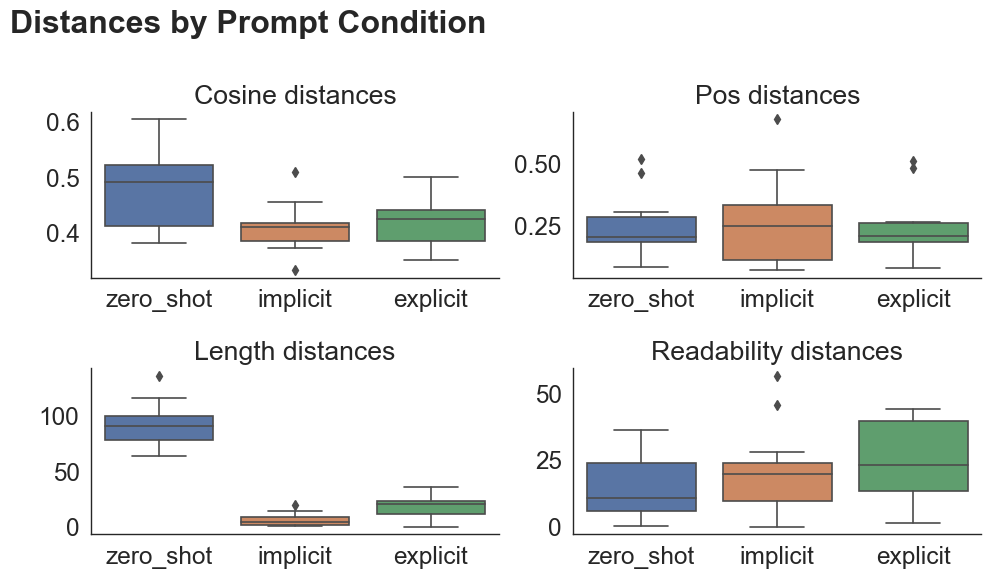

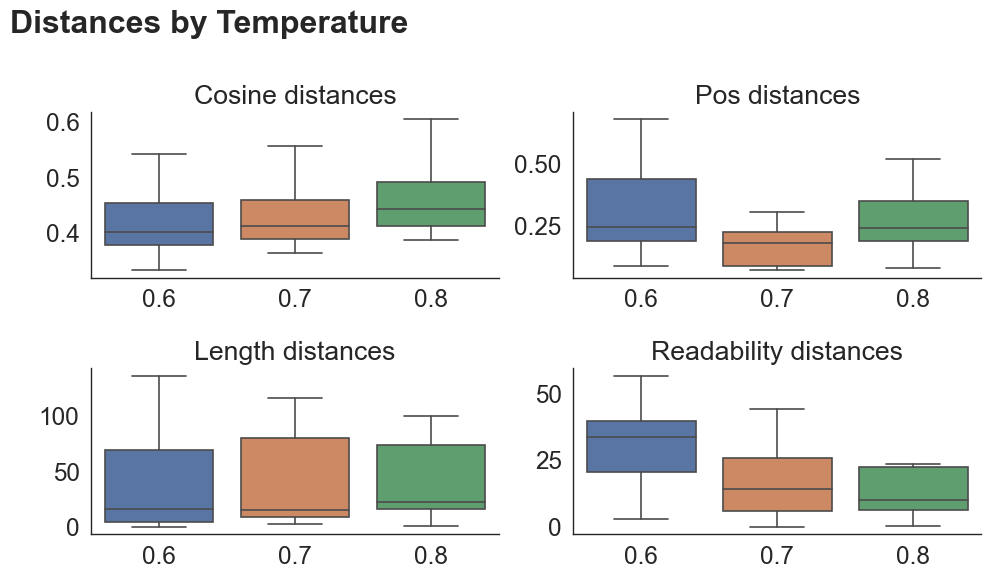

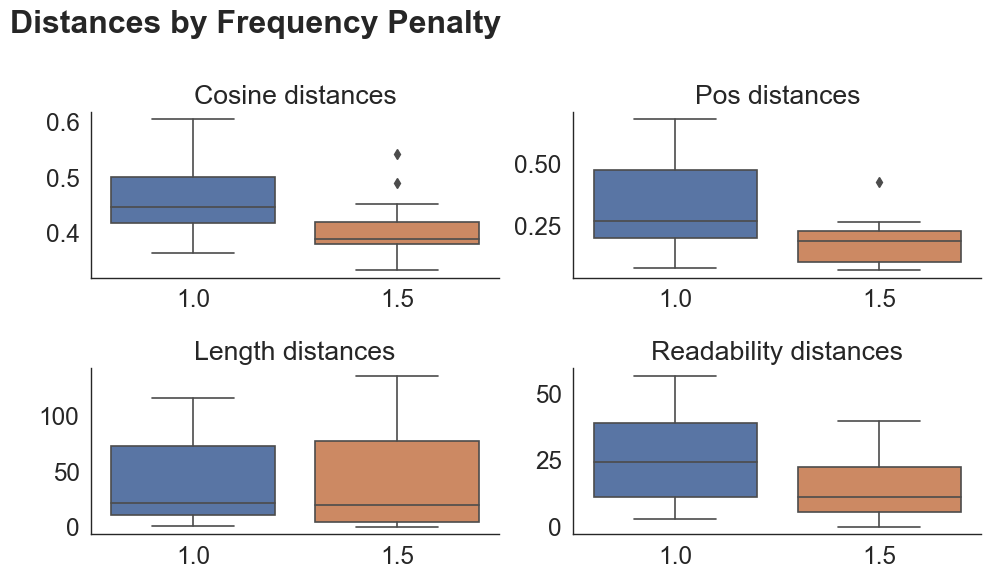

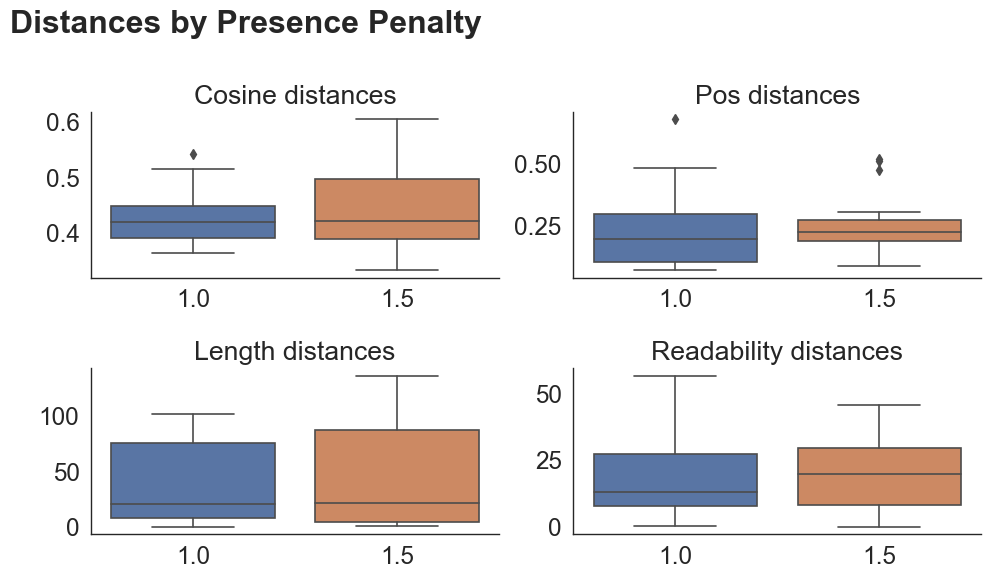

In [35]:
def make_aesthetic():
    sns.set(style='white', context='paper', font_scale=2)
    plt.rcParams.update({'font.family':'Arial'})

def make_graph(id_var):
    title_str = (id_var.replace("_", " ")).title()
    make_aesthetic()
    distance_df = res[[id_var, 'cosine_distances', 'pos_distances', 'length_distances', 'readability_distances']]
    melted_distance_df = distance_df.melt(id_vars=[id_var], var_name='distance_metric', value_name='distance')
    distance_metrics = ['cosine_distances', 'pos_distances', 'length_distances', 'readability_distances']
    fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey=False)

    for ax, metric in zip(axes.flatten(), distance_metrics):
        sns.boxplot(x=id_var, y='distance', data=melted_distance_df[melted_distance_df['distance_metric'] == metric],  ax=ax)
        ax.set_title(metric.replace('_', ' ').capitalize())
        ax.set_xlabel('')
        ax.set_ylabel('')

    fig.suptitle('Distances by {}'.format(title_str), fontweight='bold', x=0, ha='left')

    plt.tight_layout()
    sns.despine()

    plt.savefig(f"{id_var}_difs.png")
    plt.show()

for iv in ivs:
    make_graph(iv)


# Parameters

In [139]:
res.columns

Index(['prompt_condition', 'trial_no', 'idx', 'examples', 'output_responses',
       'n_examples', 'temperature', 'frequency_penalty', 'presence_penalty',
       'output', 'output_embeddings', 'example_embeddings',
       'output_bert_embeddings', 'example_bert_embeddings', 'output_pos_dists',
       'example_pos_dists', 'output_length', 'example_length',
       'output_readability', 'example_readability', 'cosine_old_distances',
       'cosine_distances', 'pos_distances', 'length_distances',
       'readability_distances'],
      dtype='object')

In [134]:
res.columns

Index(['prompt_condition', 'trial_no', 'idx', 'examples', 'output_responses',
       'n_examples', 'temperature', 'frequency_penalty', 'presence_penalty',
       'output', 'output_embeddings', 'example_embeddings',
       'output_bert_embeddings', 'example_bert_embeddings', 'output_pos_dists',
       'example_pos_dists', 'output_length', 'example_length',
       'output_readability', 'example_readability', 'cosine_old_distances',
       'cosine_distances', 'pos_distances', 'length_distances',
       'readability_distances'],
      dtype='object')